## Dependencias

In [71]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from datetime import date,time,datetime
from dateutil.relativedelta import relativedelta as rd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,mean_absolute_error
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

from varclushi import VarClusHi
from scipy import stats

from functools import reduce
from itertools import combinations

import json 
from glob import glob 
import os

from multiprocessing import Pool

from warnings import filterwarnings

pd.set_option('display.max_columns',None)
pd.set_option('display.float_format',lambda x:'%.2f'%x)
filterwarnings('ignore')
cf.go_offline()

## Lectura de datos

In [ ]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/stocks/full_history/*.csv'

In [ ]:
larch = sorted(glob(ruta))

In [ ]:
larch= sorted(np.random.choice(larch,replace=False,size=int(len(larch)*0.05)))

In [ ]:
len(set(larch)),len(larch)

In [ ]:
def leer_archivo(arch:str)->pd.DataFrame:
    """Lee el archivo de acciones y cambia el tipo de dato de acuerdo con lo mínimo necesario.
    Agrega el nombre de la acción (símbolo)

    Args:
        arch (str): La ruta completa del archivo.

    Returns:
        pd.DataFrame: Conjunto de datos tratado.
    """
    var = ['date','volume','open','high','low','close']
    df = pd.read_csv(arch,usecols=var,dtype=str)
    accion = arch.split('/')[-1].split('.')[0]
    for v in var:
        if v=='date':
            df[v] = pd.to_datetime(df[v],format='%Y-%m-%d').dt.date
        else:
            df[v] = pd.to_numeric(df[v],errors='coerce')
    df.insert(0,'stock',accion)
    return df

In [ ]:
def make_pool(func, params, threads):
    """
    Ejecuta de forma paralela múltiples llamadas a una función
    :param func: function, objeto función a paralelizar
    :param params: iterable, parámetros de evaluación paralela
    :param threads: int, número de hilos de multiprocesamiento
    :return: list, resultado de la ejecución paralela agrupada en una lista
    """
    pool = Pool(threads)
    data = pool.starmap(func, params)
    pool.close()
    pool.join()
    del pool
    return [x for x in data]

In [ ]:
df = pd.concat(make_pool(leer_archivo,[(a,) for a in larch],40),ignore_index=True)
display(df.shape)
df.head()

## Ingeniería de Características

In [ ]:
df['dif'] = df['high']-df['low']

In [ ]:
varc = ['volume','open','high','low','close','dif']

In [ ]:
df = df.loc[df['date']>=pd.to_datetime('2011-01-01')].reset_index(drop=True)
df = df.loc[~df['stock'].isin(['MTL','TY'])].reset_index(drop=True)

In [ ]:
catfh = df[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
catfh['mes'] = catfh['date'].map(lambda x:x.strftime('%Y%m'))
aux = catfh[['mes']].drop_duplicates().sort_values(by='mes').reset_index(drop=True)
aux.insert(0,'id_mes',aux.index+1)
catfh = catfh.merge(aux,on='mes',how='inner')
catfh = catfh.loc[catfh['id_mes']<115].reset_index(drop=True)
catfh.tail()

In [ ]:
df.drop(df.filter(like='mes').columns,axis=1,inplace=True)

In [ ]:
df = df.merge(catfh,on='date',how='inner')
df.head()

In [ ]:
vobs = 12
vdes = 1
step = 3


In [ ]:
def ingX(df:pd.DataFrame,ancla:int,sub:int)->pd.DataFrame:
    """Crea la representación vectorial de la acción anclada a un momento particular del tiempo
    utilizando una sub-ventana de tiempo determinada.

    Args:
        df (pd.DataFrame): Datos Transaccionales
        ancla (int): ancla que fungirá como t0
        sub (int): sub-ventana de tiempo (en meses)

    Returns:
        pd.DataFrame: Matriz de predictoras para la combinación ancla-acción
    """
    aux = df.loc[(df['id_mes']<=ancla)&(df['id_mes']>=(ancla-sub+1))].copy().reset_index(drop=True)
    piv = aux.pivot(index='stock',columns='date',values='close')
    piv.columns = range(len(piv.columns))
    for i,t in enumerate(zip(piv.columns[1:],piv.columns)):
        piv[f'dif_{i}'] = (piv[t[0]]-piv[t[1]])/piv[t[1]]
        piv[f'inc_{i}'] = (piv[t[1]]>piv[t[0]])
        piv[f'dec_{i}'] = (piv[t[1]]<piv[t[0]])
    piv[f'x_incpct_prom_{sub}'] = piv.filter(like='dif_').mean(axis=1)
    piv.drop(piv.filter(like='dif_').columns,axis=1,inplace=True)
    for t in ['inc','dec']:
        piv[f'x_num_{t}precio_{sub}'] = piv.filter(like=f'{t}_').mean(axis=1)
        piv.drop(piv.filter(like=f'{t}_').columns,axis=1,inplace=True)
    piv = piv.filter(like='x_').reset_index()
    piv.insert(1,'ancla',ancla)
    for v1,v2 in combinations(varc,2):
        aux[f'ratio_{v1}_{v2}'] = aux[v1]/aux[v2]
    ratios = sorted(aux.filter(like='ratio_').columns)
    aux = aux[['stock']+varc+ratios].groupby('stock').agg(['min','max','mean','median','std'])
    aux.columns = [f'x_{f}_{v}_{sub}' for f,v in aux.columns]
    aux.reset_index(inplace=True)
    aux.insert(1,'ancla',ancla)
    return aux.merge(piv,on=['stock','ancla'],how='inner')

In [ ]:
anclai, anclaf = df['id_mes'].min(),df['id_mes'].max()
anclai, anclaf = anclai+vobs-1,anclaf-vdes
anclai, anclaf

In [ ]:
um = ['stock','ancla']

In [ ]:
cruzar = lambda x,y: pd.merge(x,y,on=um,how='outer')
apilar = lambda x,y: pd.concat([x,y],ignore_index=True)

In [ ]:
def repVect (ancla:int)->pd.DataFrame:
    """Genera la represntación vectorial para las sub-anclas

    Args:
        ancla (int): ancla específica

    Returns:
        pd.DataFrame: Matriz de predictoras
    """
    return reduce(cruzar,map(lambda sub:ingX(df,ancla,sub),range(step,vobs+step,step)))

In [ ]:
X = reduce(apilar,make_pool(repVect,[(a,) for a in range(anclai,anclaf+1)],20))

In [ ]:
def ingY(df:pd.DataFrame,ancla:int)->pd.DataFrame:
    """Crea la variable objetivo para un ancla específica

    Args:
        df (pd.DataFrame): Datos Transaccionales
        ancla (int): ancla que fungirá como t0

    Returns:
        pd.DataFrame: Vector respuesta para la combinación ancla-acción
    """
    aux = df.loc[(df['id_mes']>ancla)&(df['id_mes']<=(ancla+vdes))].copy().reset_index(drop=True)[['stock','date','close','id_mes']]
    aux.sort_values(by=['stock','date','id_mes'],inplace=True)
    aux = aux.groupby(['stock','id_mes']).last().reset_index()
    aux.insert(1,'ancla',ancla)
    aux.rename(columns={'close':'cierre_sig_mes'},inplace=True)
    return aux.drop(['date','id_mes'],axis=1)

In [ ]:
y = reduce(apilar,map(lambda ancla:ingY(df,ancla),range(anclai,anclaf+1)))
y.shape

In [ ]:
X.shape,y.shape

In [ ]:
tad = X.merge(y,on=um,how='inner')
tad.to_pickle('tad_acciones.pkl')

In [8]:
tad = pd.read_pickle('tad_acciones.pkl')

In [9]:
tad.shape

(26682, 435)

In [10]:
tad.head()

,stock,ancla,x_volume_min_3,x_volume_max_3,x_volume_mean_3,x_volume_median_3,x_volume_std_3,x_open_min_3,x_open_max_3,x_open_mean_3,x_open_median_3,x_open_std_3,x_high_min_3,x_high_max_3,x_high_mean_3,x_high_median_3,x_high_std_3,x_low_min_3,x_low_max_3,x_low_mean_3,x_low_median_3,x_low_std_3,x_close_min_3,x_close_max_3,x_close_mean_3,x_close_median_3,x_close_std_3,x_dif_min_3,x_dif_max_3,x_dif_mean_3,x_dif_median_3,x_dif_std_3,x_ratio_close_dif_min_3,x_ratio_close_dif_max_3,x_ratio_close_dif_mean_3,x_ratio_close_dif_median_3,x_ratio_close_dif_std_3,x_ratio_high_close_min_3,x_ratio_high_close_max_3,x_ratio_high_close_mean_3,x_ratio_high_close_median_3,x_ratio_high_close_std_3,x_ratio_high_dif_min_3,x_ratio_high_dif_max_3,x_ratio_high_dif_mean_3,x_ratio_high_dif_median_3,x_ratio_high_dif_std_3,x_ratio_high_low_min_3,x_ratio_high_low_max_3,x_ratio_high_low_mean_3,x_ratio_high_low_median_3,x_ratio_high_low_std_3,x_ratio_low_close_min_3,x_ratio_low_close_max_3,x_ratio_low_close_mean_3,x_ratio_low_close_median_3,x_ratio_low_close_std_3,x_ratio_low_dif_min_3,x_ratio_low_dif_max_3,x_ratio_low_dif_mean_3,x_ratio_low_dif_median_3,x_ratio_low_dif_std_3,x_ratio_open_close_min_3,x_ratio_open_close_max_3,x_ratio_open_close_mean_3,x_ratio_open_close_median_3,x_ratio_open_close_std_3,x_ratio_open_dif_min_3,x_ratio_open_dif_max_3,x_ratio_open_dif_mean_3,x_ratio_open_dif_median_3,x_ratio_open_dif_std_3,x_ratio_open_high_min_3,x_ratio_open_high_max_3,x_ratio_open_high_mean_3,x_ratio_open_high_median_3,x_ratio_open_high_std_3,x_ratio_open_low_min_3,x_ratio_open_low_max_3,x_ratio_open_low_mean_3,x_ratio_open_low_median_3,x_ratio_open_low_std_3,x_ratio_volume_close_min_3,x_ratio_volume_close_max_3,x_ratio_volume_close_mean_3,x_ratio_volume_close_median_3,x_ratio_volume_close_std_3,x_ratio_volume_dif_min_3,x_ratio_volume_dif_max_3,x_ratio_volume_dif_mean_3,x_ratio_volume_dif_median_3,x_ratio_volume_dif_std_3,x_ratio_volume_high_min_3,x_ratio_volume_high_max_3,x_ratio_volume_high_mean_3,x_ratio_volume_high_median_3,x_ratio_volume_high_std_3,x_ratio_volume_low_min_3,x_ratio_volume_low_max_3,x_ratio_volume_low_mean_3,x_ratio_volume_low_median_3,x_ratio_volume_low_std_3,x_ratio_volume_open_min_3,x_ratio_volume_open_max_3,x_ratio_volume_open_mean_3,x_ratio_volume_open_median_3,x_ratio_volume_open_std_3,x_incpct_prom_3,x_num_incprecio_3,x_num_decprecio_3,x_volume_min_6,x_volume_max_6,x_volume_mean_6,x_volume_median_6,x_volume_std_6,x_open_min_6,x_open_max_6,x_open_mean_6,x_open_median_6,x_open_std_6,x_high_min_6,x_high_max_6,x_high_mean_6,x_high_median_6,x_high_std_6,x_low_min_6,x_low_max_6,x_low_mean_6,x_low_median_6,x_low_std_6,x_close_min_6,x_close_max_6,x_close_mean_6,x_close_median_6,x_close_std_6,x_dif_min_6,x_dif_max_6,x_dif_mean_6,x_dif_median_6,x_dif_std_6,x_ratio_close_dif_min_6,x_ratio_close_dif_max_6,x_ratio_close_dif_mean_6,x_ratio_close_dif_median_6,x_ratio_close_dif_std_6,x_ratio_high_close_min_6,x_ratio_high_close_max_6,x_ratio_high_close_mean_6,x_ratio_high_close_median_6,x_ratio_high_close_std_6,x_ratio_high_dif_min_6,x_ratio_high_dif_max_6,x_ratio_high_dif_mean_6,x_ratio_high_dif_median_6,x_ratio_high_dif_std_6,x_ratio_high_low_min_6,x_ratio_high_low_max_6,x_ratio_high_low_mean_6,x_ratio_high_low_median_6,x_ratio_high_low_std_6,x_ratio_low_close_min_6,x_ratio_low_close_max_6,x_ratio_low_close_mean_6,x_ratio_low_close_median_6,x_ratio_low_close_std_6,x_ratio_low_dif_min_6,x_ratio_low_dif_max_6,x_ratio_low_dif_mean_6,x_ratio_low_dif_median_6,x_ratio_low_dif_std_6,x_ratio_open_close_min_6,x_ratio_open_close_max_6,x_ratio_open_close_mean_6,x_ratio_open_close_median_6,x_ratio_open_close_std_6,x_ratio_open_dif_min_6,x_ratio_open_dif_max_6,x_ratio_open_dif_mean_6,x_ratio_open_dif_median_6,x_ratio_open_dif_std_6,x_ratio_open_high_min_6,x_ratio_open_high_max_6,x_ratio_open_high_mean_6,x_ratio_open_high_median_6,x_ratio_open_high_std_6,x_ratio_open_low_min_6,x_ratio_open_low_max_6,x_ratio_open_low_mean_6,x_ratio_open_low_median_6,x_ratio_open_lo

In [11]:
varc = sorted(tad.filter(like='x_').columns)
len(varc)

432

In [12]:
vart = ['cierre_sig_mes']
um = ['stock','ancla']

## Partición

In [13]:
rs = np.random.RandomState(seed=2301)
Sn, ot = [d for _,d in tad.groupby(tad['ancla']>102)]
train,valid = train_test_split(Sn,train_size=0.7,random_state=rs)

train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
ot.reset_index(drop=True,inplace=True)

train.shape,valid.shape,ot.shape

((16059, 435), (6883, 435), (3740, 435))

## Análisis Exploratorio de Datos

### Continuo

In [14]:
for v in varc:
    train[v] = pd.to_numeric(train[v],errors='coerce').replace({np.inf:np.nan,-np.inf:np.nan})

#### Ausentes

In [16]:
miss = 1-train[varc].describe().T[['count']]/len(train)
miss.sort_values(by='count',ascending=False,inplace=True)
miss

,count
x_ratio_volume_dif_std_12,0.25
x_ratio_close_dif_std_12,0.25
x_ratio_high_dif_std_12,0.25
x_ratio_low_dif_std_12,0.25
x_ratio_open_dif_std_12,0.25
...,...
x_ratio_open_high_mean_9,0.00
x_ratio_open_high_median_12,0.00
x_ratio_open_high_median_9,0.00
x_ratio_open_high_min_9,0.00


In [17]:
im = SimpleImputer(strategy='median')
im.fit(train[varc])
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi.dropna().shape,Xi.shape

((16059, 432), (16059, 432))

In [18]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],train[v]).statistic),varc),columns=['var','ks'])

In [19]:
ks.sort_values(by='ks',ascending=False)

,var,ks
348,x_ratio_volume_dif_std_12,0.25
268,x_ratio_open_dif_std_12,0.25
228,x_ratio_low_dif_std_12,0.25
128,x_ratio_close_dif_std_12,0.25
168,x_ratio_high_dif_std_12,0.25
...,...,...
279,x_ratio_open_high_mean_9,0.00
280,x_ratio_open_high_median_12,0.00
135,x_ratio_high_close_max_9,0.00
284,x_ratio_open_high_min_12,0.00


In [20]:
fuera = list(ks[ks['ks']>0.1]['var'])
len(fuera)

60

In [21]:
varc = [v for v in varc if v not in fuera]
train.drop(fuera,axis=1,inplace=True)

#### Varianza Explicada

In [22]:
vt = VarianceThreshold()
vt.fit(Xi)

VarianceThreshold()

In [23]:
fuera = [v for v,var in zip(varc,vt.get_support()) if not var]
print(len(fuera))
varc = [v for v in varc if v not in fuera]

0


#### Multicolinealidad

In [24]:
vc = VarClusHi(df=Xi.sample(n=500),feat_list=varc)
vc.varclus()

In [25]:
best = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
len(best)

24

#### Poder Predictivo

In [27]:
Xi[um] = train[um]

In [28]:
Xi = Xi.merge(train[um+vart],on=um,how='inner')

In [32]:
sk = SelectKBest(k=4,score_func=mutual_info_regression)

In [33]:
sk.fit(Xi[best],Xi[vart[0]])

SelectKBest(k=4, score_func=<function mutual_info_regression at 0x7f30680838b0>)

In [34]:
pd.DataFrame(zip(best,sk.scores_),
columns=['var','score']).sort_values(by='score',ascending=False).set_index('var').iplot(kind='bar',color='purple')

In [35]:
best = [v for v,queda in zip(best,sk.get_support()) if queda]
len(best)

4

#### Extremos

##### Predictoras 

array([[<AxesSubplot:title={'center':'x_high_max_3'}>,
        <AxesSubplot:title={'center':'x_ratio_volume_high_min_12'}>],
       [<AxesSubplot:title={'center':'x_ratio_open_dif_min_9'}>,
        <AxesSubplot:title={'center':'x_ratio_high_low_min_9'}>]],
      dtype=object)

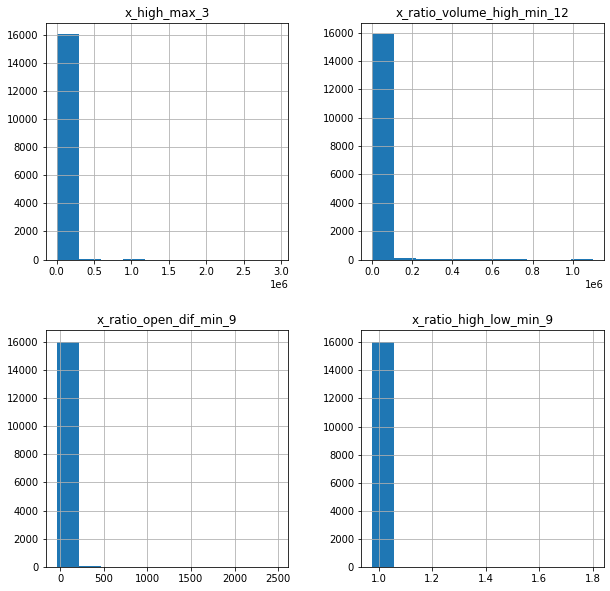

In [38]:
Xi[best].hist(figsize=(10,10))

In [39]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [40]:
Xi['ex'].value_counts(1)

0   0.94
1   0.06
Name: ex, dtype: float64

In [41]:
Xi[um] = train[um]

array([[<AxesSubplot:title={'center':'x_high_max_3'}>,
        <AxesSubplot:title={'center':'x_ratio_volume_high_min_12'}>],
       [<AxesSubplot:title={'center':'x_ratio_open_dif_min_9'}>,
        <AxesSubplot:title={'center':'x_ratio_high_low_min_9'}>]],
      dtype=object)

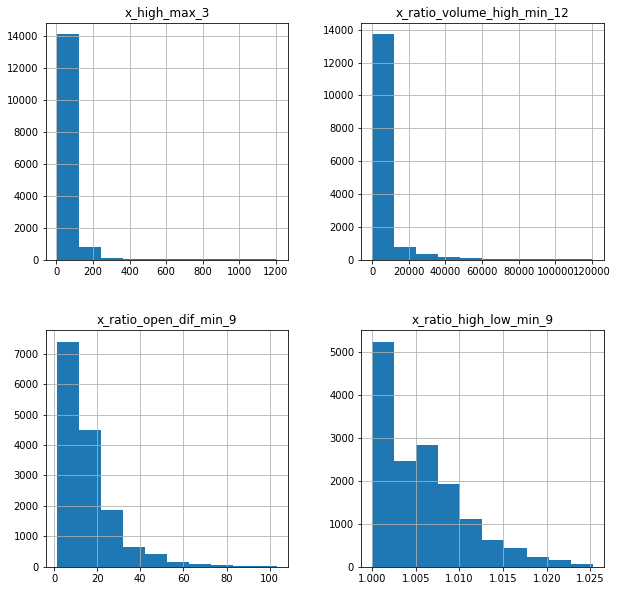

In [43]:
Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[best].hist(figsize=(10,10))

In [44]:
Xi = Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[um+best]

In [45]:
Xi.head()

,stock,ancla,x_high_max_3,x_ratio_volume_high_min_12,x_ratio_open_dif_min_9,x_ratio_high_low_min_9
0,CI,28,66.94,8541.11,12.12,1.01
1,LPTH,81,2.84,7106.92,3.04,1.00
2,WLTW,64,125.17,638.71,12.83,1.01
3,PAC,60,97.05,160.73,14.27,1.01
4,EE,68,48.38,1200.92,17.14,1.01


In [47]:
Xi = Xi.merge(train[um+vart],on=um,how='inner')

In [49]:
for v,li,ls in Xi[vart].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [50]:
Xi['ex'].value_counts(1)

0   0.98
1   0.02
Name: ex, dtype: float64

array([[<AxesSubplot:title={'center':'cierre_sig_mes'}>]], dtype=object)

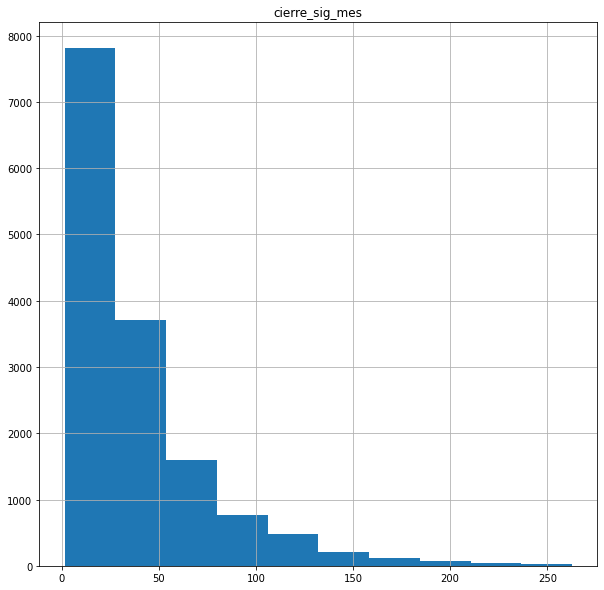

In [51]:
Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[vart].hist(figsize=(10,10))

In [52]:
Xi = Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[um+best+vart]

#### Consideraciones Finales

In [53]:
im.fit(train[best])

SimpleImputer(strategy='median')

## Espacio escalado (híper-caja)

In [55]:
sc = MinMaxScaler()
scy = MinMaxScaler()

In [58]:
sc.fit(Xi[best])
scy.fit(Xi[vart])

MinMaxScaler()

In [66]:
Xt = pd.DataFrame(sc.transform(Xi[best]),columns=best)
yt = scy.transform(Xi[vart]).reshape(-1)

In [69]:
Xt.describe()

,x_high_max_3,x_ratio_volume_high_min_12,x_ratio_open_dif_min_9,x_ratio_high_low_min_9
count,14840.00,14840.00,14840.00,14840.00
mean,0.05,0.03,0.14,0.22
std,0.05,0.09,0.13,0.20
min,0.00,0.00,0.00,0.00
25%,0.01,0.00,0.05,0.04
50%,0.03,0.00,0.10,0.20
75%,0.06,0.03,0.18,0.33
max,1.00,1.00,1.00,1.00


## Aprendizaje

### Red Neuronal

In [72]:
rn = MLPRegressor()

In [74]:
hp = {"activation" : ['identity', 'logistic', 'tanh', 'relu'],
"learning_rate" : ['constant', 'invscaling', 'adaptive'],
"hidden_layer_sizes": [(a,b,c, ) for a in range(2,20) for b in range(2,20) for c in range(2,20)],
"max_iter" : [1000] }

In [80]:
from functools import reduce
reduce(lambda x,y:x*y,map(len,[y for _,y in hp.items()]))

69984

In [81]:
grid = RandomizedSearchCV(estimator=rn,
param_distributions=hp,n_jobs=-1,verbose=True,scoring='neg_mean_absolute_error',cv=10,n_iter=100)

In [82]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=MLPRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(2, 2, 2),
                                                               (2, 2, 3),
                                                               (2, 2, 4),
                                                               (2, 2, 5),
                                                               (2, 2, 6),
                                                               (2, 2, 7),
                                                               (2, 2, 8),
                                                               (2, 2, 9),
                                                               (2, 2, 10),
                                                               (2, 2, 11),
                                

In [83]:
grid.best_score_

-0.015617699708527758

In [ ]:
rn = grid.best_estimator_

### Random Forest

In [84]:
rf = RandomForestRegressor()

In [86]:
hp = {"n_estimators" : range(2,100),
"criterion" : ["mse", "mae"],
"max_depth": range(2,20),
"min_samples_split" : np.arange(0.01,0.1,0.01) }
reduce(lambda x,y:x*y,map(len,[y for _,y in hp.items()]))

In [90]:
grid = RandomizedSearchCV(estimator=rf,
param_distributions=hp,n_jobs=-1,verbose=True,scoring='neg_mean_absolute_error',cv=4,n_iter=20)

In [91]:
grid.fit(Xt,yt)
grid.best_score_

Fitting 4 folds for each of 20 candidates, totalling 80 fits


-0.014598963029736702

In [92]:
rf = grid.best_estimator_

### Regresión Lineal

In [93]:
rl = LinearRegression()

In [94]:
rl.fit(Xt,yt)

LinearRegression()

In [95]:
mean_absolute_error(y_true=yt,y_pred=rl.predict(Xt))

0.024570087744113428

### Extra-trees 

In [96]:
et = ExtraTreesRegressor()

In [97]:
hp = {"n_estimators" : range(2,100),
"criterion" : ["mse", "mae"],
"max_depth": range(2,20),
"min_samples_split" : np.arange(0.01,0.1,0.01) }
reduce(lambda x,y:x*y,map(len,[y for _,y in hp.items()]))

31752

In [99]:
grid = RandomizedSearchCV(estimator=et,
param_distributions=hp,n_jobs=-1,verbose=True,scoring='neg_mean_absolute_error',cv=4,n_iter=10)

In [100]:
grid.fit(Xt,yt)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=ExtraTreesRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': range(2, 20),
                                        'min_samples_split': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'n_estimators': range(2, 100)},
                   scoring='neg_mean_absolute_error', verbose=True)

In [103]:
grid.best_score_

-0.014503725557324631

In [104]:
et = grid.best_estimator_

## Validación del Modelo

3.6842629129537805


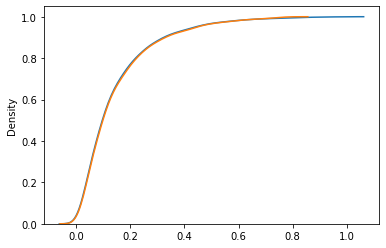

In [140]:
sns.kdeplot(yt,cumulative=True)
sns.kdeplot(et.predict(Xt),cumulative=True)
print(mean_absolute_error(y_true=scy.inverse_transform(yt.reshape(Xt.shape[0],1)),y_pred=scy.inverse_transform(et.predict(Xt).reshape(Xt.shape[0],1)).reshape(-1,1)))

In [122]:
for v in best:
    valid[v] = valid[v].replace({-np.inf:np.nan,np.inf:np.nan})

In [131]:
Xi = pd.DataFrame(im.transform(valid[best]),columns=best)

In [132]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [135]:
Xi['ex'].value_counts(1)

0   0.94
1   0.06
Name: ex, dtype: float64

In [136]:
valid ['ex']= Xi['ex']

In [137]:
Xv = sc.transform(im.transform(valid.loc[valid['ex']==0][best].reset_index(drop=True)))
yv = scy.transform(valid.loc[valid['ex']==0][vart].reset_index(drop=True)).reshape(-1)

7.963512313718903


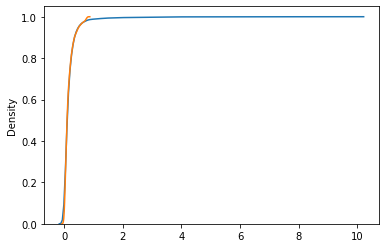

In [139]:
sns.kdeplot(yv,cumulative=True)
sns.kdeplot(et.predict(Xv),cumulative=True)
print(mean_absolute_error(y_true=scy.inverse_transform(yv.reshape(Xv.shape[0],1)),y_pred=scy.inverse_transform(et.predict(Xv).reshape(Xv.shape[0],1)).reshape(-1,1)))

In [150]:
display(pd.DataFrame(scy.inverse_transform(yt.reshape(Xt.shape[0],1))).describe())
display(pd.DataFrame(scy.inverse_transform(yv.reshape(Xv.shape[0],1))).describe())
display(pd.DataFrame(scy.inverse_transform(et.predict(Xv).reshape(Xv.shape[0],1)).reshape(-1,1)).describe())

,0
count,14840.00
mean,38.27
std,37.25
min,1.50
25%,13.23
50%,26.17
75%,50.13
max,262.71


,0
count,6491.00
mean,44.44
std,80.47
min,0.03
25%,13.03
50%,26.17
75%,51.92
max,2629.01


,0
count,6491.00
mean,40.78
std,41.20
min,1.76
25%,13.32
50%,26.55
75%,52.57
max,208.90


In [152]:
for v in best:
    ot[v] = ot[v].replace({-np.inf:np.nan,np.inf:np.nan})

In [153]:
Xi = pd.DataFrame(im.transform(ot[best]),columns=best)

In [154]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [155]:
Xi['ex'].value_counts(1)

0   0.93
1   0.07
Name: ex, dtype: float64

In [156]:
ot ['ex']= Xi['ex']

In [157]:
Xot = sc.transform(im.transform(ot.loc[valid['ex']==0][best].reset_index(drop=True)))
yot = scy.transform(ot.loc[valid['ex']==0][vart].reset_index(drop=True)).reshape(-1)

6.562689210158445


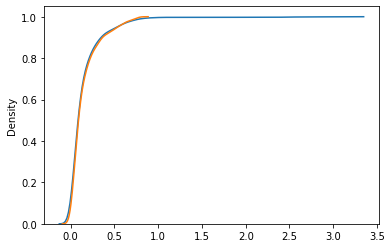

In [158]:
sns.kdeplot(yot,cumulative=True)
sns.kdeplot(et.predict(Xot),cumulative=True)
print(mean_absolute_error(y_true=scy.inverse_transform(yot.reshape(Xot.shape[0],1)),y_pred=scy.inverse_transform(et.predict(Xot).reshape(Xot.shape[0],1)).reshape(-1,1)))

In [159]:
display(pd.DataFrame(scy.inverse_transform(yt.reshape(Xt.shape[0],1))).describe())
display(pd.DataFrame(scy.inverse_transform(yot.reshape(Xot.shape[0],1))).describe())
display(pd.DataFrame(scy.inverse_transform(et.predict(Xot).reshape(Xot.shape[0],1)).reshape(-1,1)).describe())

,0
count,14840.00
mean,38.27
std,37.25
min,1.50
25%,13.23
50%,26.17
75%,50.13
max,262.71


,0
count,3531.00
mean,38.62
std,55.18
min,0.25
25%,10.41
50%,22.77
75%,44.93
max,843.43


,0
count,3531.00
mean,39.33
std,42.23
min,1.76
25%,12.07
50%,24.89
75%,48.94
max,208.19


In [169]:
sanity_check = pd.concat([pd.DataFrame(scy.inverse_transform(yot.reshape(Xot.shape[0],1)).reshape(-1,1),columns=['y_true']),
pd.DataFrame(scy.inverse_transform(et.predict(Xot).reshape(Xot.shape[0],1)).reshape(-1,1),columns=['y_pred'])],axis=1)

In [170]:
sanity_check.sample(10)

,y_true,y_pred
1466,9.55,9.50
511,46.76,44.39
1252,26.94,25.71
2008,8.19,11.92
3179,93.57,90.50
926,5.60,6.32
2251,23.07,26.34
1884,3.74,5.88
1555,64.87,66.11
2990,37.81,47.05


In [171]:
train

,stock,ancla,x_volume_min_3,x_volume_max_3,x_volume_mean_3,x_volume_median_3,x_volume_std_3,x_open_min_3,x_open_max_3,x_open_mean_3,x_open_median_3,x_open_std_3,x_high_min_3,x_high_max_3,x_high_mean_3,x_high_median_3,x_high_std_3,x_low_min_3,x_low_max_3,x_low_mean_3,x_low_median_3,x_low_std_3,x_close_min_3,x_close_max_3,x_close_mean_3,x_close_median_3,x_close_std_3,x_dif_min_3,x_dif_max_3,x_dif_mean_3,x_dif_median_3,x_dif_std_3,x_ratio_close_dif_min_3,x_ratio_close_dif_median_3,x_ratio_high_close_min_3,x_ratio_high_close_max_3,x_ratio_high_close_mean_3,x_ratio_high_close_median_3,x_ratio_high_close_std_3,x_ratio_high_dif_min_3,x_ratio_high_dif_median_3,x_ratio_high_low_min_3,x_ratio_high_low_max_3,x_ratio_high_low_mean_3,x_ratio_high_low_median_3,x_ratio_high_low_std_3,x_ratio_low_close_min_3,x_ratio_low_close_max_3,x_ratio_low_close_mean_3,x_ratio_low_close_median_3,x_ratio_low_close_std_3,x_ratio_low_dif_min_3,x_ratio_low_dif_median_3,x_ratio_open_close_min_3,x_ratio_open_close_max_3,x_ratio_open_close_mean_3,x_ratio_open_close_median_3,x_ratio_open_close_std_3,x_ratio_open_dif_min_3,x_ratio_open_dif_median_3,x_ratio_open_high_min_3,x_ratio_open_high_max_3,x_ratio_open_high_mean_3,x_ratio_open_high_median_3,x_ratio_open_high_std_3,x_ratio_open_low_min_3,x_ratio_open_low_max_3,x_ratio_open_low_mean_3,x_ratio_open_low_median_3,x_ratio_open_low_std_3,x_ratio_volume_close_min_3,x_ratio_volume_close_max_3,x_ratio_volume_close_mean_3,x_ratio_volume_close_median_3,x_ratio_volume_close_std_3,x_ratio_volume_dif_min_3,x_ratio_volume_dif_median_3,x_ratio_volume_high_min_3,x_ratio_volume_high_max_3,x_ratio_volume_high_mean_3,x_ratio_volume_high_median_3,x_ratio_volume_high_std_3,x_ratio_volume_low_min_3,x_ratio_volume_low_max_3,x_ratio_volume_low_mean_3,x_ratio_volume_low_median_3,x_ratio_volume_low_std_3,x_ratio_volume_open_min_3,x_ratio_volume_open_max_3,x_ratio_volume_open_mean_3,x_ratio_volume_open_median_3,x_ratio_volume_open_std_3,x_incpct_prom_3,x_num_incprecio_3,x_num_decprecio_3,x_volume_min_6,x_volume_max_6,x_volume_mean_6,x_volume_median_6,x_volume_std_6,x_open_min_6,x_open_max_6,x_open_mean_6,x_open_median_6,x_open_std_6,x_high_min_6,x_high_max_6,x_high_mean_6,x_high_median_6,x_high_std_6,x_low_min_6,x_low_max_6,x_low_mean_6,x_low_median_6,x_low_std_6,x_close_min_6,x_close_max_6,x_close_mean_6,x_close_median_6,x_close_std_6,x_dif_min_6,x_dif_max_6,x_dif_mean_6,x_dif_median_6,x_dif_std_6,x_ratio_close_dif_min_6,x_ratio_close_dif_median_6,x_ratio_high_close_min_6,x_ratio_high_close_max_6,x_ratio_high_close_mean_6,x_ratio_high_close_median_6,x_ratio_high_close_std_6,x_ratio_high_dif_min_6,x_ratio_high_dif_median_6,x_ratio_high_low_min_6,x_ratio_high_low_max_6,x_ratio_high_low_mean_6,x_ratio_high_low_median_6,x_ratio_high_low_std_6,x_ratio_low_close_min_6,x_ratio_low_close_max_6,x_ratio_low_close_mean_6,x_ratio_low_close_median_6,x_ratio_low_close_std_6,x_ratio_low_dif_min_6,x_ratio_low_dif_median_6,x_ratio_open_close_min_6,x_ratio_open_close_max_6,x_ratio_open_close_mean_6,x_ratio_open_close_median_6,x_ratio_open_close_std_6,x_ratio_open_dif_min_6,x_ratio_open_dif_median_6,x_ratio_open_high_min_6,x_ratio_open_high_max_6,x_ratio_open_high_mean_6,x_ratio_open_high_median_6,x_ratio_open_high_std_6,x_ratio_open_low_min_6,x_ratio_open_low_max_6,x_ratio_open_low_mean_6,x_ratio_open_low_median_6,x_ratio_open_low_std_6,x_ratio_volume_close_min_6,x_ratio_volume_close_max_6,x_ratio_volume_close_mean_6,x_ratio_volume_close_median_6,x_ratio_volume_close_std_6,x_ratio_volume_dif_min_6,x_ratio_volume_dif_median_6,x_ratio_volume_high_min_6,x_ratio_volume_high_max_6,x_ratio_volume_high_mean_6,x_ratio_volume_high_median_6,x_ratio_volume_high_std_6,x_ratio_volume_low_min_6,x_ratio_volume_low_max_6,x_ratio_volume_low_mean_6,x_ratio_volume_low_median_6,x_ratio_volume_low_std_6,x_ratio_volume_open_min_6,x_ratio_volume_open_max_6,x_ratio_volume_open_mean_6,x_ratio_volume_open_median_6,x_ratio_volume_open_std_6,x_incpct_prom_6,x_num_incprecio_6,x_num

<AxesSubplot:xlabel='ancla'>

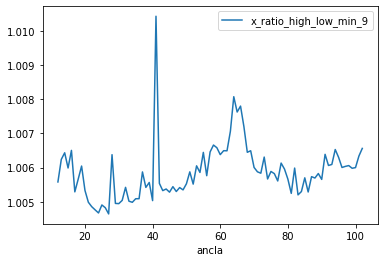

In [178]:
train[['ancla']+best[3:4]].groupby('ancla').mean().plot()

In [180]:
from sklearn.preprocessing import KBinsDiscretizer

In [244]:
l = []
for v in best:
    kb = KBinsDiscretizer(n_bins=5,strategy='kmeans',encode='ordinal')
    d = pd.DataFrame(kb.fit_transform(pd.DataFrame(im.transform(train[best]),columns=best)[[v]]),columns=[v]).assign(n=1)
    d['ancla'] = train['ancla']
    d = d.pivot_table(index='ancla',columns=v,values='n',fill_value=0,aggfunc='sum')
    d = d.assign(var=v)
    l.append(d.reset_index())

In [246]:
pd.concat(l,ignore_index=True).to_clipboard(index=False)